## Prerequesites for HTM

In [1]:
import csv
import datetime
import os
import numpy as np
import random
import math
import pprint
import matplotlib.pyplot as plt

from htm.bindings.sdr import SDR, Metrics
from htm.encoders.rdse import RDSE, RDSE_Parameters
from htm.encoders.date import DateEncoder
from htm.bindings.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood
from htm.bindings.algorithms import Predictor

## Parámetros del HTM

In [2]:
# Cargar el archivo
# __file__ = '/htm_examples'
_# EXAMPLE_DIR = os.path.dirname(os.path.abspath(__file__))
_INPUT_FILE_PATH = os.path.join("/home/capri/htm_examples/", "gymdata.csv")

# Default parameters in HTM
default_parameters = {
# there are 2 (3) encoders: "value" (RDSE) & "time" (DateTime weekend, timeOfDay)
 'enc': {
      "value" :
         {'resolution': 0.88, 'size': 700, 'sparsity': 0.02},
      "time": 
         {'timeOfDay': (30, 1), 'weekend': 21}
 },
 'predictor': {'sdrc_alpha': 0.1},
 'sp': {'boostStrength': 3.0,
        'columnCount': 1638,
        'localAreaDensity': 0.04395604395604396,
        'potentialPct': 0.85,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'synPermInactiveDec': 0.006},
 'tm': {'activationThreshold': 17,
        'cellsPerColumn': 13,
        'initialPerm': 0.21,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'minThreshold': 10,
        'newSynapseCount': 32,
        'permanenceDec': 0.1,
        'permanenceInc': 0.1},
 'anomaly': {
   'likelihood': 
       {'probationaryPct': 0.1,
        'reestimationPeriod': 100}
 }
}
        
# print("Parameters:")
# pprint.pprint(default_parameters, indent=4)
# print("")

Parameters:
{   'anomaly': {   'likelihood': {   'probationaryPct': 0.1,
                                     'reestimationPeriod': 100}},
    'enc': {   'time': {'timeOfDay': (30, 1), 'weekend': 21},
               'value': {'resolution': 0.88, 'size': 700, 'sparsity': 0.02}},
    'predictor': {'sdrc_alpha': 0.1},
    'sp': {   'boostStrength': 3.0,
              'columnCount': 1638,
              'localAreaDensity': 0.04395604395604396,
              'potentialPct': 0.85,
              'synPermActiveInc': 0.04,
              'synPermConnected': 0.13999999999999999,
              'synPermInactiveDec': 0.006},
    'tm': {   'activationThreshold': 17,
              'cellsPerColumn': 13,
              'initialPerm': 0.21,
              'maxSegmentsPerCell': 128,
              'maxSynapsesPerSegment': 64,
              'minThreshold': 10,
              'newSynapseCount': 32,
              'permanenceDec': 0.1,
              'permanenceInc': 0.1}}



## Read the Input File

In [3]:
records = []
# Leer el CSV que tiene los datos.
with open(_INPUT_FILE_PATH, "r") as fin:
    reader = csv.reader(fin)
    headers = next(reader)
    next(reader)
    next(reader)
    for record in reader:
        records.append(record)
# print(records)

## Make the Encoders

In [4]:
dateEncoder = DateEncoder(timeOfDay= default_parameters["enc"]["time"]["timeOfDay"],
                          weekend= default_parameters["enc"]["time"]["weekend"])

scalarEncoderParams             = RDSE_Parameters()
scalarEncoderParams.size        = default_parameters["enc"]["value"]["size"]
scalarEncoderParams.sparsity    = default_parameters["enc"]["value"]["sparsity"]
scalarEncoderParams.resolution  = default_parameters["enc"]["value"]["resolution"]
scalarEncoder = RDSE( scalarEncoderParams )
encodingWidth = (dateEncoder.size + scalarEncoder.size)
enc_info = Metrics( [encodingWidth], 999999999)

## Make the HTM

In [5]:
# Spatial Pooler Parameters
spParams = default_parameters["sp"]
sp = SpatialPooler(
    inputDimensions            = (encodingWidth,),
    columnDimensions           = (spParams["columnCount"],),
    potentialPct               = spParams["potentialPct"],
    potentialRadius            = encodingWidth,
    globalInhibition           = True,
    localAreaDensity           = spParams["localAreaDensity"],
    synPermInactiveDec         = spParams["synPermInactiveDec"],
    synPermActiveInc           = spParams["synPermActiveInc"],
    synPermConnected           = spParams["synPermConnected"],
    boostStrength              = spParams["boostStrength"],
    wrapAround                 = True
)
sp_info = Metrics( sp.getColumnDimensions(), 999999999 )

# Temporal Memory Parameters
tmParams = default_parameters["tm"]
tm = TemporalMemory(
    columnDimensions          = (spParams["columnCount"],),
    cellsPerColumn            = tmParams["cellsPerColumn"],
    activationThreshold       = tmParams["activationThreshold"],
    initialPermanence         = tmParams["initialPerm"],
    connectedPermanence       = spParams["synPermConnected"],
    minThreshold              = tmParams["minThreshold"],
    maxNewSynapseCount        = tmParams["newSynapseCount"],
    permanenceIncrement       = tmParams["permanenceInc"],
    permanenceDecrement       = tmParams["permanenceDec"],
    predictedSegmentDecrement = 0.0,
    maxSegmentsPerCell        = tmParams["maxSegmentsPerCell"],
    maxSynapsesPerSegment     = tmParams["maxSynapsesPerSegment"]
)
tm_info = Metrics( [tm.numberOfCells()], 999999999 )

## Setup Likelihood

In [6]:
anParams = default_parameters["anomaly"]["likelihood"]
probationaryPeriod = int(math.floor(float(anParams["probationaryPct"])*len(records)))
learningPeriod     = int(math.floor(probationaryPeriod / 2.0))
anomaly_history    = AnomalyLikelihood(learningPeriod= learningPeriod,
                                    estimationSamples= probationaryPeriod - learningPeriod,
                                    reestimationPeriod= anParams["reestimationPeriod"])

predictor = Predictor( steps=[1, 5], alpha=default_parameters["predictor"]['sdrc_alpha'] )
predictor_resolution = 1

## Iterate through every datum in dataset, record the inputs & outputs

In [7]:
inputs      = []
anomaly     = []
anomalyProb = []
predictions = {1: [], 5: []}
for count, record in enumerate(records):

    # Convert date string into Python date object.
    dateString = datetime.datetime.strptime(record[0], "%m/%d/%y %H:%M")
    
    # Convert data value string into float.
    consumption = float(record[1])
    inputs.append( consumption )

    # Call the encoders to create bit representations for each value.  These are SDR objects.
    dateBits        = dateEncoder.encode(dateString)
    consumptionBits = scalarEncoder.encode(consumption)

    # Concatenate all these encodings into one large encoding for Spatial Pooling.
    encoding = SDR( encodingWidth ).concatenate([consumptionBits, dateBits])
    enc_info.addData( encoding )

    # Create an SDR to represent active columns, This will be populated by the
    # compute method below. It must have the same dimensions as the Spatial Pooler.
    activeColumns = SDR( sp.getColumnDimensions() )

    # Execute Spatial Pooling algorithm over input space.
    sp.compute(encoding, True, activeColumns)
    sp_info.addData( activeColumns )

    # Execute Temporal Memory algorithm over active mini-columns.
    tm.compute(activeColumns, learn=True)
    tm_info.addData( tm.getActiveCells().flatten() )

    # Predict what will happen, and then train the predictor based on what just happened.
    pdf = predictor.infer( tm.getActiveCells() )
    for n in (1, 5):
        if pdf[n]:
            predictions[n].append( np.argmax( pdf[n] ) * predictor_resolution )
        else:
            predictions[n].append(float('nan'))

    anomalyLikelihood = anomaly_history.anomalyProbability( consumption, tm.anomaly )
    anomaly.append( tm.anomaly )
    anomalyProb.append( anomalyLikelihood )

    predictor.learn(count, tm.getActiveCells(), int(consumption / predictor_resolution))

## Print information & statistics about the state of HTM

Encoded Input SDR( 1462 )
    Sparsity Min/Mean/Std/Max 0.0437757 / 0.0444499 / 8.19216e-05 / 0.0444596
    Activation Frequency Min/Mean/Std/Max 0 / 0.0444494 / 0.097048 / 0.685265
    Entropy 0.694261
    Overlap Min/Mean/Std/Max 0 / 0.443191 / 0.0872024 / 0.538462

Spatial Pooler Mini-Columns SDR( 1638 )
    Sparsity Min/Mean/Std/Max 0.043956 / 0.0439559 / 2.08729e-07 / 0.043956
    Activation Frequency Min/Mean/Std/Max 0 / 0.0439561 / 0.0250202 / 0.0920065
    Entropy 0.939494
    Overlap Min/Mean/Std/Max 0 / 0.0707702 / 0.046691 / 0.319444
Spatial Pooler Connections:
    Inputs (1462) ~> Outputs (1638) via Segments (1638)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 1243 / 1243 / 1243
    Connected Synapses on Segment Min/Mean/Max 75 / 213.612 / 666
    Synapses Dead (0.725978%) Saturated (0.034328%)
    Synapses pruned (0%) Segments pruned (0%)
    Buffer for destroyed synapses: 0    Buffer for destroyed segments: 0


Temporal Memory 

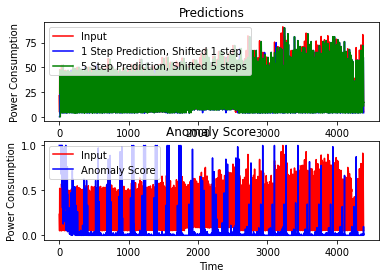

8.880373284967567


In [8]:
# Print information & statistics about the state of the HTM.
print("Encoded Input", enc_info)
print("")
print("Spatial Pooler Mini-Columns", sp_info)
print(str(sp))
print("")
print("Temporal Memory Cells", tm_info)
print(str(tm))
print("")

# Shift the predictions so that they are aligned with the input they predict.
for n_steps, pred_list in predictions.items():
    for x in range(n_steps):
        pred_list.insert(0, float('nan'))
        pred_list.pop()

# Calculate the predictive accuracy, Root-Mean-Squared
accuracy         = {1: 0, 5: 0}
accuracy_samples = {1: 0, 5: 0}

for idx, inp in enumerate(inputs):
    for n in predictions: # For each [N]umber of time steps ahead which was predicted.
        val = predictions[n][ idx ]
        if not math.isnan(val):
            accuracy[n] += (inp - val) ** 2
            accuracy_samples[n] += 1
for n in sorted(predictions):
    accuracy[n] = (accuracy[n] / accuracy_samples[n]) ** .5
    print("Predictive Error (RMS)", n, "steps ahead:", accuracy[n])

# Show info about the anomaly (mean & std)
print("Anomaly Mean", np.mean(anomaly))
print("Anomaly Std ", np.std(anomaly))

# Plot the Predictions and Anomalies.

plt.subplot(2,1,1)
plt.title("Predictions")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
plt.plot(np.arange(len(inputs)), inputs, 'red',
            np.arange(len(inputs)), predictions[1], 'blue',
            np.arange(len(inputs)), predictions[5], 'green',)
plt.legend(labels=('Input', '1 Step Prediction, Shifted 1 step', '5 Step Prediction, Shifted 5 steps'))

plt.subplot(2,1,2)
plt.title("Anomaly Score")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
inputs = np.array(inputs) / max(inputs)
plt.plot(np.arange(len(inputs)), inputs, 'red',
            np.arange(len(inputs)), anomaly, 'blue',)
plt.legend(labels=('Input', 'Anomaly Score'))
plt.show()

print(accuracy[5])